# Figures for The atlas of urban communities

### Packages

In [21]:
# TODO B delete some of these

import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import networkx as nx

import scipy
import csv

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import json
import community as community_louvain
from copy import deepcopy
# from modularity_maximization.utils import get_modularity

from itertools import product
import networkx.algorithms.community as nx_comm
from scipy.spatial.distance import pdist, squareform

from shapely.geometry import Point, LineString
from geopandas import GeoDataFrame

import math
from time import time

import matplotlib.lines as lines

import matplotlib
import sklearn.linear_model
import matplotlib.ticker as mtick

### Data

In [22]:
tract_df = pd.read_csv("../data/tract_level_data_2.csv.gz")
community_df = pd.read_csv("../data/community_level_data_2.csv.gz")
network_df = pd.read_csv("../data/network_level_data.csv.gz")

In [24]:
# edgelists
mobility = pd.read_csv("../data/usageousers_city_mobility_CT_networks.rpt.gz")
follow_hh = pd.read_csv("../data/usageousers_city_follower_CT_HH_networks.rpt.gz")


cbsacode = pd.read_csv("../data/cbsacode_shortname_tracts.csv",sep=";", index_col=0)

# reading geojson data, converting it to geopandas dataframe
tract_geoms = gpd.GeoDataFrame.from_features(
    [json.loads(e.strip('\n')) for e in open('../data/censustract_geoms_top50.geojson').readlines()]
)

# Cartesian coordinate projection of tract centroids
tract_geoms['centroid'] = tract_geoms['geometry'].centroid
tract_center_dict = tract_geoms\
    .set_geometry('centroid',crs={'init':'epsg:4326'})\
    .to_crs({'init':'epsg:3785'})\
    .set_index('full_geoid')['centroid'].map(lambda p: p.coords[0]).to_dict()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [25]:
# add city names to edgelists
cbsacode['city'] = cbsacode["short_name"].map(lambda s: s.split("/")[0].replace(' ','_').replace('.','').lower())
mobility = pd.merge(mobility, cbsacode[['geoid', 'city','short_name']], left_on = 'tract_home', right_on = 'geoid')
mobility = mobility.drop(columns = ['geoid'])
follow_hh = pd.merge(follow_hh, cbsacode[['geoid', 'city','short_name']], left_on = 'tract_home', right_on = 'geoid')
follow_hh = follow_hh.drop(columns = ['geoid'])
follow_hh = follow_hh.rename(columns={"tract_home.1": "tract_home_1"})

In [26]:
# adding normal city names
city_dict = dict(zip(cbsacode['city'],cbsacode['short_name']))
tract_df['short_name'] = tract_df['city'].map(city_dict)

In [27]:
# merge networks and coodrdinates

mobility = pd.merge(mobility,tract_geoms[['geometry','full_geoid','centroid']], left_on='tract_home', right_on='full_geoid',how='left') # on home
mobility = mobility.drop(columns='full_geoid')
mobility = mobility.rename(columns={"centroid": "centroid_home", "geometry": "polygon_home"})

mobility = pd.merge(mobility,tract_geoms[['geometry','full_geoid','centroid']], left_on='tract_work', right_on='full_geoid',how='left') # on work
mobility = mobility.drop(columns='full_geoid')
mobility = mobility.rename(columns={"centroid": "centroid_work", "geometry": "polygon_work"})

follow_hh = pd.merge(follow_hh,tract_geoms[['geometry','full_geoid','centroid']], left_on='tract_home', right_on='full_geoid',how='left') # on home_0
follow_hh = follow_hh.drop(columns='full_geoid')
follow_hh = follow_hh.rename(columns={"centroid": "centroid_home", "geometry": "polygon_home"})

follow_hh = pd.merge(follow_hh,tract_geoms[['geometry','full_geoid','centroid']], left_on='tract_home_1', right_on='full_geoid',how='left') # on home_1
follow_hh = follow_hh.drop(columns='full_geoid')
follow_hh = follow_hh.rename(columns={"centroid": "centroid_home_1", "geometry": "polygon_home_1"})

In [28]:
# colors

###colors_fol_hh_ms = ['#7f3b08','#b35806','#e08214','#fdb863','#d8daeb','#b2abd2','#8073ac','#542788','#2d004b'

colors_fol_hh_mgn_1 = ['#7f3b08','#b35806','#e08214','#fdb863','#d9f0d3','#a6dba0','#5aae61','#1b7837','#00441b'] # modified

# rearranged
colors_fol_hh_mgn = ['#7f3b08','#d9f0d3','#00441b','#b35806','#a6dba0','#e08214','#5aae61','#1b7837','#fdb863']


color_mob = '#2d004b'
color_mob_2 = '#8073ac'
color_fol_hh = '#00441b'
color_fol_hh_2 = '#5aae61'

### Figure 1 - network layout, bubble maps

# DATAPREP KÉRDÉS - EZT HOVA RAKJAM

In [ ]:
# KUKA 0615
# Create node weights for drawing the bubbles
# add up the weight from both sides of the edge

# Follower home-home
#set(follow_hh['tract_home']) - set(follow_hh['tract_home_1']) # empthy --> all the tracts which are home tracts a listed as tract_homes, so it is enoough to add up the weights for the one (of two) ways(s)

# check --> it was necessary as these are different
##set(follow_hh['cnt']*2 - follow_hh['all_home_cnt'])
fol_home_cnt_dict = dict(zip(follow_hh.tract_home,follow_hh.cnt))
fol_home_1_cnt_dict = dict(zip(follow_hh.tract_home_1,follow_hh.cnt))
all_home_cnt_dict = {k: fol_home_cnt_dict.get(k, 0) + fol_home_1_cnt_dict.get(k, 0) for k in set(fol_home_cnt_dict) | set(fol_home_1_cnt_dict)}
follow_hh['all_home_cnt'] = follow_hh['tract_home'].map(all_home_cnt_dict)



# Mobility # KERDES: Hogy lehet ezt egyszerubben?
mob_home_cnt_dict = dict(zip(mobility.tract_home,mobility.cnt))
mob_work_cnt_dict = dict(zip(mobility.tract_work,mobility.cnt))

mob_home_polygon_dict = dict(zip(mobility.tract_home,mobility.polygon_home))
mob_work_polygon_dict = dict(zip(mobility.tract_work,mobility.polygon_work))

# there are work tract that are not home tracts and vica versa
mob_cnt_dict = {k: mob_home_cnt_dict.get(k, 0) + mob_work_cnt_dict.get(k, 0) for k in set(mob_home_cnt_dict) | set(mob_work_cnt_dict)}

mob_cnt_df = pd.DataFrame.from_dict(mob_cnt_dict, orient='index').reset_index()
mob_cnt_df = mob_cnt_df.rename(columns = {'index' : 'geoid', 0 : 'cnt'})

mob_cnt_df['polygon'] = mob_cnt_df['geoid'].map(mob_home_polygon_dict)
mob_cnt_df['polygon_2'] = mob_cnt_df['geoid'].map(mob_work_polygon_dict)
mob_cnt_df['polygon'].fillna(mob_cnt_df['polygon_2'], inplace=True)
mob_cnt_df.drop(columns = 'polygon_2', inplace = True)

city_dict = dict(zip(cbsacode.geoid,cbsacode.city))
mob_cnt_df['city'] = mob_cnt_df.geoid.map(city_dict)

In [9]:
# EFÖLÖTTIEKET KI KELL RAKJA A PY-FÁJLBA???

In [29]:
# create edge lines
def line(x,y):
    return LineString([x,y])

In [30]:
# Atlas of urban communities

city_boundaries = {}

In [31]:
def degree_bubble_map(city, mobility, follow_hh, ew = 0.01, ns = 2, save = False, w=8, h=8):
    """
    For a given city draws the bubble networks on a map of 
    the mobility (communitng) and
    the socail ties (follower home-home).
    
    ex: degree_bubble_map('boston', mobility, follow_hh)
    
    """
    
    # Create edge lines
    # geometry = edges between 
    # - home and work centroids
    # - homes of follower pairs tracts' centroids
    
    # filter for the city
    mobility = deepcopy(mobility[mobility['city'] == city])
    follow_hh = deepcopy(follow_hh[follow_hh['city'] == city])
    
    # create contour
    if city not in city_boundaries:
        follow_hh = follow_hh.set_geometry(follow_hh['polygon_home'])
        follow_hh['buffered_tract'] = follow_hh.buffer(0.01)
        follow_hh = follow_hh.set_geometry(follow_hh['buffered_tract'])
        follow_hh['dissolve'] = 1
        city_boundary = follow_hh.dissolve(by = 'dissolve')
        city_boundaries[city] = city_boundary
    else:
        city_boundary = city_boundaries.get(city)
  
    mobility['geometry'] = mobility.apply(lambda row: line(row['centroid_home'],row['centroid_work']), axis = 1) # KERDES MIERT KELL? ,axis=1)
    follow_hh['geometry'] = follow_hh.apply(lambda row: line(row['centroid_home'],row['centroid_home_1']), axis = 1) #,axis=1) 

    # convert into GeoDataFrame
    gdf_mobility= GeoDataFrame(mobility, crs="EPSG:4326") # edges
    gdf_follow_hh = GeoDataFrame(follow_hh, crs="EPSG:4326")

    # GeoDataFrames for the bubbles
    gdf_mobility_nodes = gdf_mobility.set_geometry('centroid_work')
    gdf_follow_hh_nodes = gdf_follow_hh.set_geometry('centroid_home')

    
    # Draw figure
#     f, ax = plt.subplots(1,2, figsize=(16,8))
    f, ax = plt.subplots(1,1, figsize=(w,h))
#     f.suptitle(city, fontsize = 20)
    
    # mobility
#     ax[0].set_title('Commuting', size = 16)
#     gdf_mobility.plot(ax = ax[0], linewidth=gdf_mobility['cnt']*0.05, color = color_mob) # edges
#     gdf_mobility_nodes.plot(ax = ax[0], alpha=0.5, markersize=gdf_mobility_nodes['cnt']*ns, color='black')
#     city_boundary.boundary.plot(ax = ax[0], color = 'black')
#     ax[0].set_axis_off()

    # fol_hh
#     ax.set_title('Social ties', size = 16)
    city_boundary.plot(ax = ax, facecolor = 'lightgrey', edgecolor=None, alpha=0.7)
    gdf_follow_hh.plot(ax = ax, alpha = 0.7, linewidth = gdf_follow_hh['cnt']*ew, color = color_fol_hh)  #'#33a02c')#'#01665e')#'#1b7837')#'#542788')# #########'#762a83')# #    
    # TODO - miert vannak fekete es szurke csucsok is?
    gdf_follow_hh_nodes.plot(ax = ax, alpha=0.2, markersize = gdf_follow_hh_nodes['all_home_cnt'].astype('float')*2, color='black')
    ax.set_axis_off()
    
    filename = 'slide_bubble_maps_' + city
    # savefig(filename, dpi=1200, bbox_inches='tight')
    if save:
        plt.savefig("../figures/" + filename  + ".png", dpi=300, bbox_inches='tight')
    else:
        plt.show()


    # TODO CHECK AND CORRECT SIZES

### Figure 2 - maps colored with NG and Spa communities

In [33]:
# Atlas_of_urban_com
# depreciated comments cut

# Consensus community map drawer
def community_map(city, g_type, tract_df, save = False):
    """
    For a given network and algorithm used for calculating communities,
    it draws the colored community map eith tract boundaries.
    
    It uses the previously loaded `tract_geoms` GeoDataFrame in which geometrical data is stored,
    the `tract_df` pandas.DataFrames, in which consensus clustering labels are stored
    and colors_fol_hh_mgn color list.
    
    ex: community_map('boston','fol_hh', tract_df)
    
    Parameters:
    -----------
    city : str
        name of the city, lowercase, '_' instead of ' '
        
    g_type : str
        either "mob" as mobility or "fol_hh" as follow_hh 
        selects the type of graph to return
        
    tract_df : pd.DataFrame
        contains community labels for each tract
        
    Returns:
    --------
    
    plot maps and save it to figures
        
    """
    
    # filter data to the given network's given communities
    map_df = deepcopy(tract_df[(tract_df['city'] == city) & (tract_df['g_type'] == g_type)])
    # merge to geodata
    map_tracts = pd.merge(tract_geoms[['geometry', 'full_geoid', 'centroid']], map_df, left_on='full_geoid', right_on='geoid')      
    
    f, ax = plt.subplots(2,1, figsize=(22,16))
    #f.suptitle(city + ' '+ g_type, fontsize = 20)
    # JAVITANI
    #f.suptitle('Communities based on socail ties in Boston', fontsize = 20) ### JAVÍTANI!!!!
    
    # Newman-Girwan
#     ax[0].set_title('Newman-Girvan', size = 16)
    map_tracts_mgn = deepcopy(map_tracts[map_tracts['algorithm_type'] == 'mgn'])
    cmap = matplotlib.colors.ListedColormap(colors_fol_hh_mgn_1)
    map_tracts_mgn.plot(ax=ax[0], column = 'S', cmap=cmap, legend=True)
    map_tracts.boundary.plot(ax=ax[0], color='grey', linewidth=0.025)
    #map_tracts.centroid.plot(ax=ax, color='red', markersize=0.5)
    ax[0].set_axis_off()
    ax[1].annotate(cbsacode[["short_name","city"]].drop_duplicates().set_index("city")["short_name"].to_dict().get(city),
                  (0.5,0.5),xycoords="figure fraction",fontsize=35)
    map_tracts_ms = deepcopy(map_tracts[map_tracts['algorithm_type'] == 'ms'])
    # SAME cmap = matplotlib.colors.ListedColormap(colors_fol_hh_ms)
    map_tracts_ms.plot(ax=ax[1], column = 'S', cmap=cmap, legend=True)
    map_tracts.boundary.plot(ax=ax[1], color='grey', linewidth=0.025)
    #map_tracts.centroid.plot(ax=ax, color='red', markersize=0.5)
    ax[1].set_axis_off()
    
    
    f.delaxes(f.axes[2]) # remove colorbar
    f.delaxes(f.axes[2]) # from the second part of figure too
    
    plt.subplots_adjust(hspace = 0.2)
    plt.tight_layout()
#     plt.show()
    if save:
        plt.savefig("../figures/slide_coloredmap_"+city+".png", density=300, bbox_inches='tight')

### Figure 3 - community quality & demography scatterplots made from communities

In [34]:
plt.rcParams['font.size']=13

In [35]:
community_df.columns

Index(['S', 'city', 'algorithm_type', 'g_type', 'degree_avg_x',
       'degreecent_avg', 'modularity_S', 'modularity', 'mod_S_p', 'tract_sum',
       'population_sum_1', 'income_sum_1', 'educ_ba_sum_1', 'white_sum_1',
       'black_sum_1', 'native_sum_1', 'asian_sum_1', 'population_std_1',
       'income_std_1', 'educ_ba_std_1', 'white_std_1', 'black_std_1',
       'native_std_1', 'asian_std_1', 'income_1_l', 'income_pct',
       'degree_avg_y', 'population_avg_1', 'educ_ba_avg_1', 'income_avg_1',
       'white_avg_1', 'black_avg_1', 'native_avg_1', 'asian_avg_1',
       'educ_ba_p_diff_avg_1', 'white_p_diff_avg_1', 'black_p_diff_avg_1',
       'native_p_diff_avg_1', 'asian_p_diff_avg_1', 'income_diff_avg_1'],
      dtype='object')

In [36]:
title_dict = {
    'income_diff_avg_1' : 'Income diff. from city avg.',
    'black_p_diff_avg_1' : 'Black population % diff. from city avg.',
    'educ_ba_p_diff_avg_1' : 'Higher ed. % diff. from city avg.'
}

In [37]:
# Stats_of_urban_com

def community_scatter_pair(demo):
    
    # filter out small communities
    community_df_filt = community_df[community_df['tract_sum'] > 10]
    
    community_df_ms_fol_hh = deepcopy(community_df_filt[(community_df_filt['algorithm_type'] == 'ms') & (community_df_filt['g_type'] == 'fol_hh')])
    community_df_mgn_fol_hh = deepcopy(community_df_filt[(community_df_filt['algorithm_type'] == 'mgn') & (community_df_filt['g_type'] == 'fol_hh')])
    
    fig, ax = plt.subplots(1,2, figsize = (14,7))#, sharey = True) # 0604
    #fig.suptitle('Correlation of communities and their incomes', fontsize=20)
    
    x_mgn = community_df_mgn_fol_hh['mod_S_p']
    y_mgn = community_df_mgn_fol_hh[demo]
    w_mgn = community_df_mgn_fol_hh['tract_sum']
    
    # filt[er out nan-s for the slope calculations - KERDES ez igy jo?
    mask_mgn = ~np.isnan(x_mgn) & ~np.isnan(y_mgn)
        
    x_mgn = community_df_mgn_fol_hh['mod_S_p'][mask_mgn]
    y_mgn = community_df_mgn_fol_hh[demo][mask_mgn]
    w_mgn = community_df_mgn_fol_hh['tract_sum'][mask_mgn]
   
    model_mgn = sklearn.linear_model.LinearRegression()
    
    xx_mgn = np.array([x_mgn]).T
    yy_mgn = np.array([y_mgn]).T
    ww_mgn = np.array(w_mgn).T
    
    model_mgn.fit(xx_mgn, yy_mgn, sample_weight = ww_mgn)
    line_x_mgn = np.array([np.linspace(min(x_mgn), max(x_mgn), 100)]).T
    pred_mgn = model_mgn.predict(line_x_mgn)
    y_pred_mgn = model_mgn.predict(xx_mgn)
    r_mgn = sklearn.metrics.r2_score(yy_mgn, y_pred_mgn, sample_weight = ww_mgn)
    intercept_mgn = model_mgn.intercept_[0]
    slope_mgn = model_mgn.coef_[0][0]
    line_mgn = f'y={intercept_mgn:.2f}+{slope_mgn:.2f}x, r={r_mgn:.2f}'
    
    ax[0].plot(line_x_mgn, pred_mgn,label=None)

    ax[0].scatter(x_mgn, y_mgn, c = 'purple', alpha = 0.5, label=None)
    
    ax[0].plot(x_mgn, intercept_mgn + slope_mgn * x_mgn, c = 'purple', label=line_mgn)
    
    ax[0].set_title('Newman-Girvan', size = 14, pad=15)
   
    
    ax[0].set_xlabel('Modularity contribution', size = 14)
    ax[0].set_ylabel(title_dict.get(demo,demo), size = 14)
    ax[0].xaxis.set_major_formatter(mtick.PercentFormatter(1)) # % format
    #ax[0].grid()
    ax[0].legend(loc='upper right')

    
    # EXPERT
    
    x_ms = community_df_ms_fol_hh['mod_S_p']
    y_ms = community_df_ms_fol_hh[demo]
    w_ms = community_df_ms_fol_hh['tract_sum']    
    
    # filt[er out nan-s for the slope calculations - KERDES ez igy jo?
    mask_ms = ~np.isnan(x_ms) & ~np.isnan(y_ms)
    
    x_ms = community_df_ms_fol_hh['mod_S_p'][mask_ms]
    y_ms = community_df_ms_fol_hh[demo][mask_ms]
    w_ms = community_df_ms_fol_hh['tract_sum'][mask_ms]
    
    xx_ms = np.array([x_ms]).T
    yy_ms = np.array([y_ms]).T
    ww_ms = np.array(w_ms).T
    
    model_ms = sklearn.linear_model.LinearRegression()    
    model_ms.fit(xx_ms, yy_ms, sample_weight = ww_ms)

    line_x_ms = np.array([np.linspace(min(x_ms), max(x_ms), 100)]).T
    pred_ms = model_ms.predict(line_x_ms)
    
    y_pred_ms = model_ms.predict(xx_ms)
    
    r_ms = sklearn.metrics.r2_score(yy_ms, y_pred_ms, sample_weight = ww_ms)
    
    
    intercept_ms = model_ms.intercept_[0]
    slope_ms = model_ms.coef_[0][0]
    
    line_ms = f'y={intercept_ms:.2f}+{slope_ms:.2f}x, r={r_ms:.2f}' # TODO megnezni, hogy mi az az f-string
    
    ax[1].plot(line_x_ms, pred_ms)   
    ax[1].scatter(x_ms, y_ms, c = 'green', alpha = 0.5,label=None) # 0616 label = 'Social ties Expert')
    ax[1].plot(x_ms, intercept_ms + slope_ms * x_ms, c = 'green', label=line_ms)
    
    # TODO color with city
    
    
    ax[1].set_title('Expert', size = 14, pad=15)
    
    
    x_min = min(min(x_mgn) * 0.9 - 0.00001, min(x_ms) * 0.9 - 0.00001) # x axis same
    x_max = max(max(x_mgn)*1.1, max(x_ms)*1.1)
    ax[0].set_xlim(x_min, x_max)
    ax[1].set_xlim(x_min, x_max)
    
    y_min = min(min(y_mgn) * 0.9 - 0.00001, min(y_ms) * 0.9 - 0.00001) # y axis shared
    y_max = max(max(y_mgn)*1.1, max(y_ms)*1.1)
    ax[0].set_ylim(y_min, y_max)
    ax[1].set_ylim(y_min, y_max)
       
    ax[1].set_xlabel('Modularity contribution', size = 14)
    ax[1].xaxis.set_major_formatter(mtick.PercentFormatter(1.0)) # % format
        
    #ax[1].grid()
    ax[1].legend(loc='upper right')
    
    plt.show()
    #plt.savefig('../figures/slides_scatter_' + demo+'.png',dpi=300)

In [6]:
# Check if modularity contribution correlates with community size - color -demo

#### 6 scatterplots in one

In [47]:
def community_scatter():
    
    # filter out small communities
    community_df_filt = community_df[community_df['tract_sum'] > 10]
    
    community_df_ms_fol_hh = deepcopy(community_df_filt[(community_df_filt['algorithm_type'] == 'ms') & (community_df_filt['g_type'] == 'fol_hh')])
    community_df_mgn_fol_hh = deepcopy(community_df_filt[(community_df_filt['algorithm_type'] == 'mgn') & (community_df_filt['g_type'] == 'fol_hh')])
    
    fig, ax = plt.subplots(2,3, figsize = (28,15))
    
    x_mgn = community_df_mgn_fol_hh['mod_S_p']
    y_mgn_1 = community_df_mgn_fol_hh['income_diff_avg_1']
    y_mgn_2 = community_df_mgn_fol_hh['educ_ba_p_diff_avg_1']
    y_mgn_3 = community_df_mgn_fol_hh['black_p_diff_avg_1']
    w_mgn = community_df_mgn_fol_hh['tract_sum']
    
    
    # FILTER OUT NAN
    # filt[er out nan-s for the slope calculations - KERDES ez igy jo?
    mask_mgn_1 = ~np.isnan(x_mgn) & ~np.isnan(y_mgn_1)
    mask_mgn_2 = ~np.isnan(x_mgn) & ~np.isnan(y_mgn_2)
    mask_mgn_3 = ~np.isnan(x_mgn) & ~np.isnan(y_mgn_3)
        
    x_mgn_f_1 = x_mgn[mask_mgn_1]
    y_mgn_f_1 = y_mgn_1[mask_mgn_1]
    w_mgn_f_1 = community_df_mgn_fol_hh['tract_sum'][mask_mgn_1]
    
    x_mgn_f_2 = x_mgn[mask_mgn_2]
    y_mgn_f_2 = y_mgn_2[mask_mgn_2]
    w_mgn_f_2 = community_df_mgn_fol_hh['tract_sum'][mask_mgn_2]
    
    x_mgn_f_3 = x_mgn[mask_mgn_3]
    y_mgn_f_3 = y_mgn_3[mask_mgn_3]
    w_mgn_f_3 = community_df_mgn_fol_hh['tract_sum'][mask_mgn_3]
    
    
    xx_mgn_1 = np.array([x_mgn_f_1]).T
    yy_mgn_1 = np.array([y_mgn_f_1]).T
    ww_mgn_1 = np.array(w_mgn_f_1).T
    
    xx_mgn_2 = np.array([x_mgn_f_2]).T
    yy_mgn_2 = np.array([y_mgn_f_2]).T
    ww_mgn_2 = np.array(w_mgn_f_2).T
    
    xx_mgn_3 = np.array([x_mgn_f_3]).T
    yy_mgn_3 = np.array([y_mgn_f_3]).T
    ww_mgn_3 = np.array(w_mgn_f_3).T
    
    
    model_mgn_1 = sklearn.linear_model.LinearRegression()
    model_mgn_2 = sklearn.linear_model.LinearRegression()
    model_mgn_3 = sklearn.linear_model.LinearRegression()
    
    
    #1 (income)
    model_mgn_1.fit(xx_mgn_1, yy_mgn_1, sample_weight = ww_mgn_1)
    line_x_mgn_1 = np.array([np.linspace(min(x_mgn), max(x_mgn), 100)]).T
    pred_mgn_1 = model_mgn_1.predict(line_x_mgn_1)
    y_pred_mgn_1 = model_mgn_1.predict(xx_mgn_1)
    r_mgn_1 = sklearn.metrics.r2_score(yy_mgn_1, y_pred_mgn_1, sample_weight = ww_mgn_1)
    intercept_mgn_1 = model_mgn_1.intercept_[0]
    slope_mgn_1 = model_mgn_1.coef_[0][0]
    line_mgn_1 = f'y={intercept_mgn_1:.2f}+{slope_mgn_1:.2f}x, r={r_mgn_1:.2f}'
    
    #2 (educ)
    model_mgn_2.fit(xx_mgn_2, yy_mgn_2, sample_weight = ww_mgn_2)
    line_x_mgn_2 = np.array([np.linspace(min(x_mgn), max(x_mgn), 100)]).T
    pred_mgn_2 = model_mgn_2.predict(line_x_mgn_2)
    y_pred_mgn_2 = model_mgn_2.predict(xx_mgn_2)
    r_mgn_2 = sklearn.metrics.r2_score(yy_mgn_2, y_pred_mgn_2, sample_weight = ww_mgn_2)
    intercept_mgn_2 = model_mgn_2.intercept_[0]
    slope_mgn_2 = model_mgn_2.coef_[0][0]
    line_mgn_2 = f'y={intercept_mgn_2:.2f}+{slope_mgn_2:.2f}x, r={r_mgn_2:.2f}'
    
    
    #3 (black)
    model_mgn_3.fit(xx_mgn_3, yy_mgn_3, sample_weight = ww_mgn_3)
    line_x_mgn_3 = np.array([np.linspace(min(x_mgn), max(x_mgn), 100)]).T
    pred_mgn_3 = model_mgn_3.predict(line_x_mgn_3)
    y_pred_mgn_3 = model_mgn_3.predict(xx_mgn_3)
    r_mgn_3 = sklearn.metrics.r2_score(yy_mgn_3, y_pred_mgn_3, sample_weight = ww_mgn_3)
    intercept_mgn_3 = model_mgn_3.intercept_[0]
    slope_mgn_3 = model_mgn_3.coef_[0][0]
    line_mgn_3 = f'y={intercept_mgn_3:.2f}+{slope_mgn_3:.2f}x, r={r_mgn_3:.2f}'   
    

    # NG_1 (income)
    ax[0,0].plot(line_x_mgn_1, pred_mgn_1,label=None)
    ax[0,0].scatter(x_mgn, y_mgn_1, c = 'purple', alpha = 0.5, label=None) # KERDES: ide miert nem a szurteket rakom be?
    ax[0,0].plot(x_mgn, intercept_mgn_1 + slope_mgn_1 * x_mgn, c = 'purple', label=line_mgn_1)
    ax[0,0].set_title('Newman-Girvan', size = 14, pad=15)
    ax[0,0].set_xlabel('Modularity contribution', size = 14)
    ax[0,0].set_ylabel(title_dict.get('income_diff_avg_1','income_diff_avg_1'), size = 14) # KERDES: honnan jon ez a demo-demo dict?
    ax[0,0].xaxis.set_major_formatter(mtick.PercentFormatter(1)) # % format
    #ax[0,0].grid()
    ax[0,0].legend(loc='upper right') 
    
    
    # NG_2 (educ)
    ax[0,1].plot(line_x_mgn_2, pred_mgn_2,label=None)
    ax[0,1].scatter(x_mgn, y_mgn_2, c = 'purple', alpha = 0.5, label=None)
    ax[0,1].plot(x_mgn, intercept_mgn_2 + slope_mgn_2 * x_mgn, c = 'purple', label=line_mgn_2)
    ax[0,1].set_title('Newman-Girvan', size = 14, pad=15)
    ax[0,1].set_xlabel('Modularity contribution', size = 14)
    ax[0,1].set_ylabel(title_dict.get('educ_ba_p_diff_avg_1','educ_ba_p_diff_avg_1'), size = 14)
    ax[0,1].xaxis.set_major_formatter(mtick.PercentFormatter(1)) # % format
    #ax[0,1].grid()
    ax[0,1].legend(loc='upper right')
    
    # NG_3 (black)
    ax[0,2].plot(line_x_mgn_3, pred_mgn_3,label=None)
    ax[0,2].scatter(x_mgn, y_mgn_3, c = 'purple', alpha = 0.5, label=None)
    ax[0,2].plot(x_mgn, intercept_mgn_3 + slope_mgn_3 * x_mgn, c = 'purple', label=line_mgn_3)
    ax[0,2].set_title('Newman-Girvan', size = 14, pad=15)
    ax[0,2].set_xlabel('Modularity contribution', size = 14)
    ax[0,2].set_ylabel(title_dict.get('black_p_diff_avg_1','black_p_diff_avg_1'), size = 14)
    ax[0,2].xaxis.set_major_formatter(mtick.PercentFormatter(1)) # % format
    #ax[0,2].grid()
    ax[0,2].legend(loc='upper right')

    
    
    
    
    # EXPERT
    
    x_ms = community_df_ms_fol_hh['mod_S_p']  
    y_ms_1 = community_df_ms_fol_hh['income_diff_avg_1']
    y_ms_2 = community_df_ms_fol_hh['educ_ba_p_diff_avg_1']
    y_ms_3 = community_df_ms_fol_hh['black_p_diff_avg_1']
    w_ms = community_df_ms_fol_hh['tract_sum']    
    
    # filt[er out nan-s for the slope calculations - KERDES ez igy jo?
    mask_ms_1 = ~np.isnan(x_ms) & ~np.isnan(y_ms_1)
    mask_ms_2 = ~np.isnan(x_ms) & ~np.isnan(y_ms_2)
    mask_ms_3 = ~np.isnan(x_ms) & ~np.isnan(y_ms_3)
    
    x_ms_f_1 = community_df_ms_fol_hh['mod_S_p'][mask_ms_1]
    y_ms_f_1 = community_df_ms_fol_hh['income_diff_avg_1'][mask_ms_1]
    w_ms_f_1 = community_df_ms_fol_hh['tract_sum'][mask_ms_1]
    
    x_ms_f_2 = community_df_ms_fol_hh['mod_S_p'][mask_ms_2]
    y_ms_f_2 = community_df_ms_fol_hh['educ_ba_p_diff_avg_1'][mask_ms_2]
    w_ms_f_2 = community_df_ms_fol_hh['tract_sum'][mask_ms_2]
    
    x_ms_f_3 = community_df_ms_fol_hh['mod_S_p'][mask_ms_3]
    y_ms_f_3 = community_df_ms_fol_hh['black_p_diff_avg_1'][mask_ms_3]
    w_ms_f_3 = community_df_ms_fol_hh['tract_sum'][mask_ms_3]
    
    
    xx_ms_1 = np.array([x_ms_f_1]).T
    yy_ms_1 = np.array([y_ms_f_1]).T
    ww_ms_1 = np.array(w_ms_f_1).T
    
    xx_ms_2 = np.array([x_ms_f_2]).T
    yy_ms_2 = np.array([y_ms_f_2]).T
    ww_ms_2 = np.array(w_ms_f_2).T
    
    xx_ms_3 = np.array([x_ms_f_3]).T
    yy_ms_3 = np.array([y_ms_f_3]).T
    ww_ms_3 = np.array(w_ms_f_3).T
    
    
    model_ms_1 = sklearn.linear_model.LinearRegression()
    model_ms_2 = sklearn.linear_model.LinearRegression()
    model_ms_3 = sklearn.linear_model.LinearRegression()
    
    # MS_1 (income)
    model_ms_1.fit(xx_ms_1, yy_ms_1, sample_weight = ww_ms_1)
    line_x_ms_1 = np.array([np.linspace(min(x_ms), max(x_ms), 100)]).T # KERDES: nem baj, h ez nem szurt?
    pred_ms_1 = model_ms_1.predict(line_x_ms_1)
    y_pred_ms_1 = model_ms_1.predict(xx_ms_1)
    r_ms_1 = sklearn.metrics.r2_score(yy_ms_1, y_pred_ms_1, sample_weight = ww_ms_1)    
    intercept_ms_1 = model_ms_1.intercept_[0]
    slope_ms_1 = model_ms_1.coef_[0][0]
    line_ms_1 = f'y={intercept_ms_1:.2f}+{slope_ms_1:.2f}x, r={r_ms_1:.2f}' # TODO megnezni, hogy mi az az f-string
    
    # MS_2 (educ)
    model_ms_2.fit(xx_ms_2, yy_ms_2, sample_weight = ww_ms_2)
    line_x_ms_2 = np.array([np.linspace(min(x_ms), max(x_ms), 100)]).T # KERDES: nem baj, h ez nem szurt?
    pred_ms_2 = model_ms_2.predict(line_x_ms_2)
    y_pred_ms_2 = model_ms_2.predict(xx_ms_2)
    r_ms_2 = sklearn.metrics.r2_score(yy_ms_2, y_pred_ms_2, sample_weight = ww_ms_2)    
    intercept_ms_2 = model_ms_2.intercept_[0]
    slope_ms_2 = model_ms_2.coef_[0][0]
    line_ms_2 = f'y={intercept_ms_2:.2f}+{slope_ms_2:.2f}x, r={r_ms_2:.2f}' # TODO megnezni, hogy mi az az f-string
    
    # MS_3 (black)
    model_ms_3.fit(xx_ms_3, yy_ms_3, sample_weight = ww_ms_3)
    line_x_ms_3 = np.array([np.linspace(min(x_ms), max(x_ms), 100)]).T # KERDES: nem baj, h ez nem szurt?
    pred_ms_3 = model_ms_3.predict(line_x_ms_3)
    y_pred_ms_3 = model_ms_3.predict(xx_ms_3)
    r_ms_3 = sklearn.metrics.r2_score(yy_ms_3, y_pred_ms_3, sample_weight = ww_ms_3)    
    intercept_ms_3 = model_ms_3.intercept_[0]
    slope_ms_3 = model_ms_3.coef_[0][0]
    line_ms_3 = f'y={intercept_ms_3:.2f}+{slope_ms_3:.2f}x, r={r_ms_3:.2f}' # TODO megnezni, hogy mi az az f-string
    
    
    
    ax[1,0].plot(line_x_ms_1, pred_ms_1)   
    ax[1,0].scatter(x_ms, y_ms_1, c = 'green', alpha = 0.5,label=None) # 0616 label = 'Social ties Expert')
    ax[1,0].plot(x_ms, intercept_ms_1 + slope_ms_1 * x_ms, c = 'green', label = line_ms_1)
    # TODO color with city?
    ax[1,0].set_title('Expert', size = 14, pad=15)
    
    ax[1,1].plot(line_x_ms_2, pred_ms_2)   
    ax[1,1].scatter(x_ms, y_ms_2, c = 'green', alpha = 0.5,label=None) # 0616 label = 'Social ties Expert')
    ax[1,1].plot(x_ms, intercept_ms_2 + slope_ms_2 * x_ms, c = 'green', label = line_ms_2)
    # TODO color with city?
    ax[1,1].set_title('Expert', size = 14, pad=15)
    
    ax[1,2].plot(line_x_ms_3, pred_ms_3)   
    ax[1,2].scatter(x_ms, y_ms_3, c = 'green', alpha = 0.5,label=None) # 0616 label = 'Social ties Expert')
    ax[1,2].plot(x_ms, intercept_ms_3 + slope_ms_3 * x_ms, c = 'green', label = line_ms_3)
    # TODO color with city?
    ax[1,2].set_title('Expert', size = 14, pad=15)
    
    
    
    # SET MIN MAX on both lines (mgn/ms)
    
    x_min = min(min(x_mgn) * 0.9 - 0.00001, min(x_ms) * 0.9 - 0.00001) # x axis same
    x_max = max(max(x_mgn)*1.1, max(x_ms)*1.1)
    ax[0,0].set_xlim(x_min, x_max)
    ax[0,1].set_xlim(x_min, x_max)
    ax[0,2].set_xlim(x_min, x_max)
    ax[1,0].set_xlim(x_min, x_max)
    ax[1,1].set_xlim(x_min, x_max)
    ax[1,2].set_xlim(x_min, x_max)
    
    
    y_min_1 = min(min(y_mgn_1) * 0.9 - 0.00001, min(y_ms_1) * 0.9 - 0.00001) # y axis shared
    y_max_1 = max(max(y_mgn_1)*1.1, max(y_ms_1)*1.1)
    ax[0,0].set_ylim(y_min_1, y_max_1)
    ax[0,1].set_ylim(y_min_1, y_max_1)
    
    y_min_2 = min(min(y_mgn_2) * 0.9 - 0.00001, min(y_ms_2) * 0.9 - 0.00001) # y axis shared
    y_max_2 = max(max(y_mgn_2)*1.1, max(y_ms_2)*1.1)
    ax[0,0].set_ylim(y_min_2, y_max_2)
    ax[0,1].set_ylim(y_min_2, y_max_2)
    
    y_min_3 = min(min(y_mgn_3) * 0.9 - 0.00001, min(y_ms_3) * 0.9 - 0.00001) # y axis shared
    y_max_3 = max(max(y_mgn_3)*1.1, max(y_ms_3)*1.1)
    ax[0,0].set_ylim(y_min_3, y_max_3)
    ax[0,1].set_ylim(y_min_3, y_max_3)
    
    
    ax[1,0].set_xlabel('Modularity contribution', size = 14)
    ax[1,0].xaxis.set_major_formatter(mtick.PercentFormatter(1.0)) # % format
        
    #ax[1,0].grid()
    ax[1,0].legend(loc='upper right')
    ax[1,1].legend(loc='upper right')
    ax[1,2].legend(loc='upper right')
    
    plt.show()
    #plt.savefig('../figures/slides_scatter_' + demo+'.png',dpi=300)

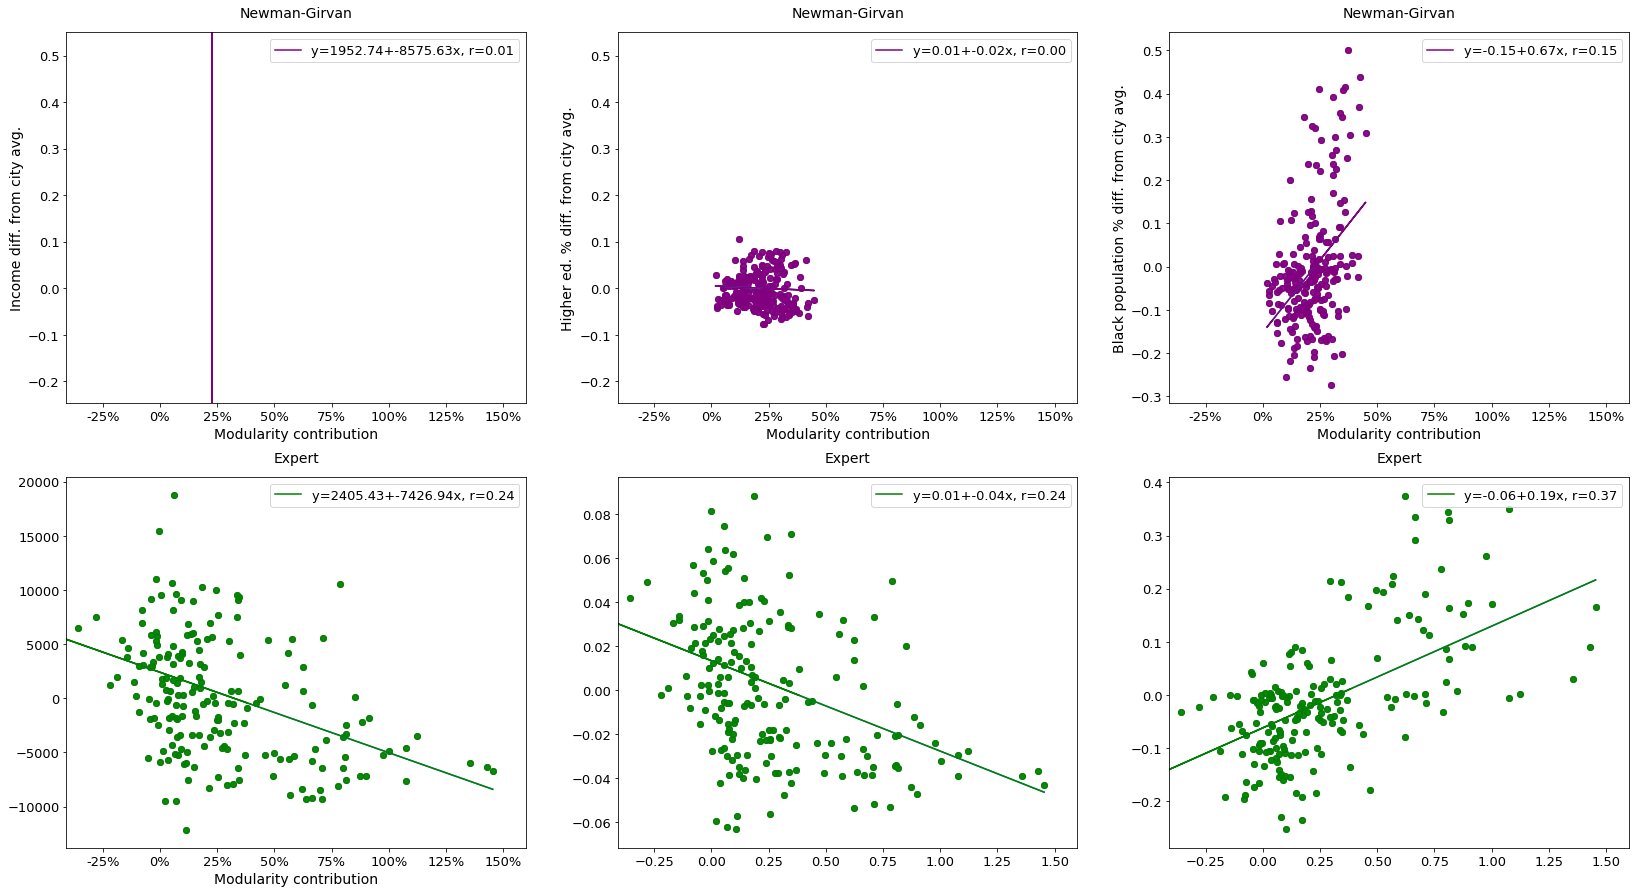

In [48]:
community_scatter()